# Illustration Showing Effect of CPD

In [1]:
from src.model.wavelet_model import *
from src.data.preprocess_utils import bin_data
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import seaborn as sns 
import numpy as np
import pickle 

sns.set_theme()

rcParams = {
    "font.family": "serif",  # use serif/main font for text elements
    'text.usetex': True,
    'font.size': 8,
    'axes.labelsize': 7,
    'axes.titlesize': 9,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 7,
    'axes.labelpad': 1,
    'axes.axisbelow': True,  # draw gridlines below other elements
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        r"\usepackage{url}",            # load additional packages
        r"\usepackage{amsmath,amssymb}",   # unicode math setup
        #  r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
}
plt.rcParams.update(rcParams)

figdir = "../../../figures/methods/"
def savefig(fig, name, width=6, height=4):
    # apply rcParams
    fig.set_size_inches(width, height)
    fig.savefig(figdir + name + ".pdf", bbox_inches='tight')


### Get data 

In [19]:
with open("simulated_data.pkl", 'rb') as f:
    file = pickle.load(f)
f.close()

channel = 5 
peaks, _ = find_peaks(file['filtered_signal'][:, channel], height = 30, distance = 2900)
bins = bin_data(file['filtered_signal'][:, channel], peaks).T 
true_bins = bin_data(file['true_signal'][:, channel], peaks).T

scales = np.arange(1, 128)

# allocate memory 
scalograms = np.zeros((bins.shape[1], len(scales), bins.shape[0]))

for bin_idx in range(bins.shape[1]):
    coefficients, _ = pywt.cwt(bins[:, bin_idx], scales=scales, wavelet='cgau1', sampling_period=1/30000)
    scalograms[bin_idx] = np.abs(coefficients)


In [ ]:
# clean scalograms 
# scalograms_clean = clean_scalograms(scalograms, rank = 30)
class options:
    def __init__(self):
        self.tol = 1e-5 
        
rank = 30 
factors, _ = tfx.cpd(scalograms, rank, options = options)


In [88]:
def reconstruct_tensor(factors, idx):
    A, B, C = factors  # Unpack factor matrices
    R = A.shape[1]  # Rank of the decomposition

    # Initialize tensor with zeros
    X_reconstructed = np.zeros((A.shape[0], B.shape[0], C.shape[0]))

    # Sum over rank components
    for r in range(R):
        if r in idx: 
            continue
        X_reconstructed += np.outer(A[:, r], B[:, r])[:, :, None] * C[:, r][None, None, :]

    return X_reconstructed

idx = np.where(all_acfs > 0.5)[0]
scalograms_clean = reconstruct_tensor(factors, idx)

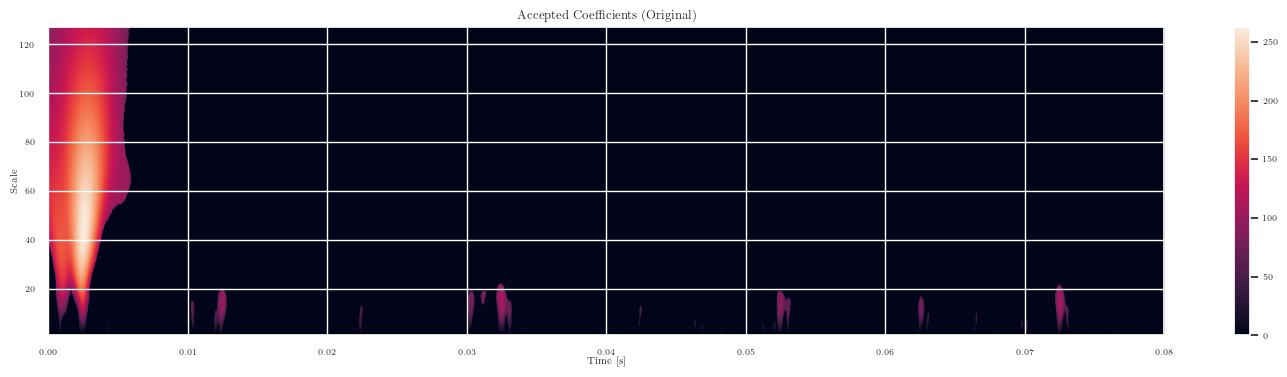

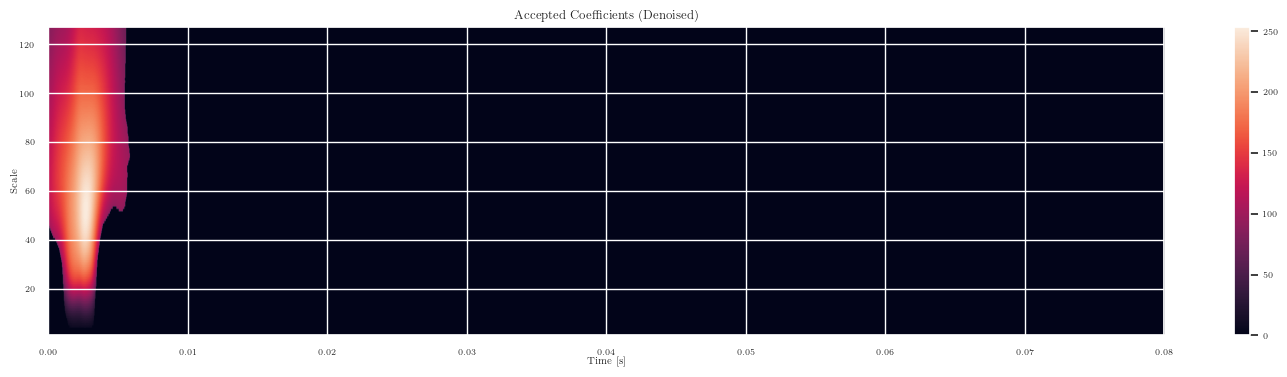

In [90]:
idx = 1
accept_orig = get_accepted_coefficients(scalograms[idx], scales, 0.1)
accept_clean = get_accepted_coefficients(scalograms_clean[idx], scales, 0.1)

plt.figure(figsize = (18, 4))
plt.imshow(accept_orig, extent=[0, len(bins) / 30000, scales.min(), scales.max()],
           aspect='auto', origin='lower')
plt.xlabel('Time [s]')
plt.ylabel('Scale')
plt.title('Accepted Coefficients (Original)')
plt.colorbar()
plt.show()

plt.figure(figsize = (18, 4))
plt.imshow(accept_clean, extent=[0, len(bins) / 30000, scales.min(), scales.max()],
           aspect='auto', origin='lower')
plt.xlabel('Time [s]')
plt.ylabel('Scale')
plt.title('Accepted Coefficients (Denoised)')
plt.colorbar()
plt.show()